In [1]:
from os import path
import numpy as np
from matplotlib import pyplot as plt
import zarr
import tensorflow as tf

In [2]:
data_root = "../data"

X_train_path = path.join(data_root, "data_train.npz")
y_train_path = path.join(data_root, "labels_train.npz")

In [3]:
zarr_path = path.join(data_root, "training.zarr")
# zarr_grp = zarr.open_group(zarr_path, mode="w")
# zarr_grp.create_dataset(
#     "X",
#     data=np.load(X_train_path)["data"][None, ..., None],
#     chunks=(1, 64, 64, 64, 1),
#     dtype="float32",
# )
#
# zarr_grp.create_dataset(
#     "y",
#     data=np.load(y_train_path)["labels"][None, ..., None],
#     chunks=(1, 64, 64, 64, 1),
#     dtype="uint8",
# )

train = zarr.open_group(zarr_path, mode="r")

In [4]:
def get_inline(il_idx):
    return train.X[0, :, il_idx, :, 0], train.y[0, :, il_idx, :, 0]


def get_xline(xl_idx):
    return train.X[0, ..., xl_idx, 0], train.y[0, ..., xl_idx, 0]


def get_tslice(t_idx):
    return train.X[0, t_idx, ..., 0], train.y[0, t_idx, ..., 0]


mean, std = train.X[:].mean(), train.X[:].std()

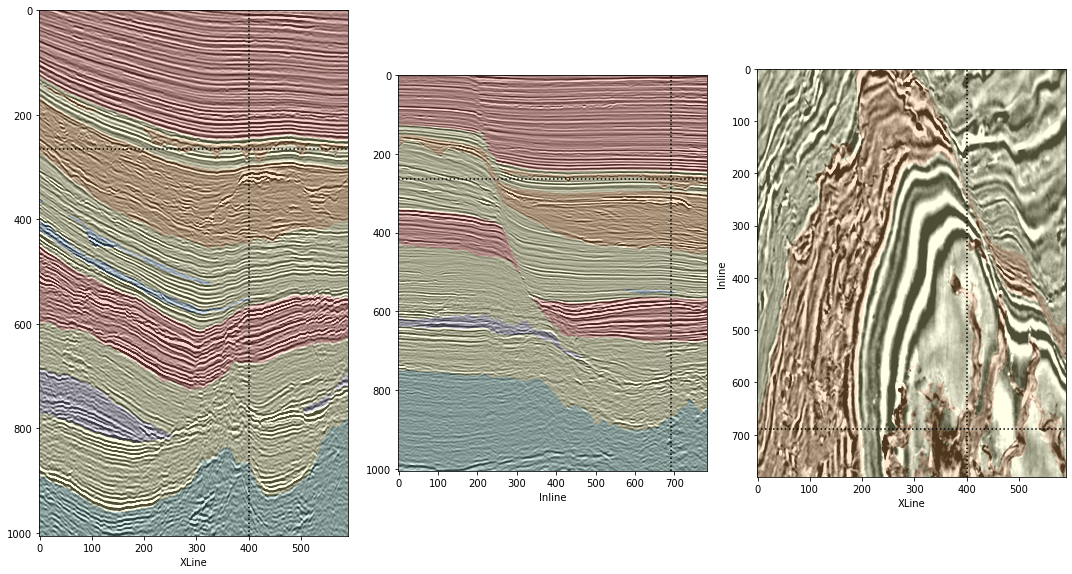

In [5]:
il_idx = 690
xl_idx = 400
t_idx = 265

il_data, il_label = get_inline(il_idx)
xl_data, xl_label = get_xline(xl_idx)
z_data, z_label = get_tslice(t_idx)

vmin, vmax = mean - std, mean + std
seismic_kw = dict(vmin=vmin, vmax=vmax, cmap="gray_r", interpolation="bicubic")
label_kw = dict(vmin=0.5, vmax=12.5, cmap="Set3", interpolation="nearest")

fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(il_label, **label_kw)
ax[0].imshow(il_data, **seismic_kw, alpha=0.7)
ax[0].axhline(t_idx, color="k", linestyle=":")
ax[0].axvline(xl_idx, color="k", linestyle=":")
ax[0].set_xlabel("XLine")

ax[1].imshow(xl_label, **label_kw)
ax[1].imshow(xl_data, **seismic_kw, alpha=0.7)
ax[1].axhline(t_idx, color="k", linestyle=":")
ax[1].axvline(il_idx, color="k", linestyle=":")
ax[1].set_xlabel("Inline")

ax[2].imshow(z_label, **label_kw)
ax[2].imshow(z_data, **seismic_kw, alpha=0.7)
ax[2].axhline(il_idx, color="k", linestyle=":")
ax[2].axvline(xl_idx, color="k", linestyle=":")
ax[2].set_xlabel("XLine")
ax[2].set_ylabel("Inline")

fig.tight_layout()

In [6]:
patch_size = (64,) * 3
strides = (64,) * 3
batch_patch_size = (1,) + patch_size + (1,)
batch_strides = (1,) + strides + (1,)

X_full = tf.extract_volume_patches(train.X, batch_patch_size, batch_strides, padding="SAME")
y_full = tf.extract_volume_patches(train.y, batch_patch_size, batch_strides, padding="SAME")
X_full = (X_full - mean) / std

X_full = tf.reshape(X_full, (-1,) + patch_size + (1,))
y_full = tf.reshape(y_full, (-1,) + patch_size + (1,))

2022-02-24 13:31:01.695232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-24 13:31:01.695334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


(-1, 1)

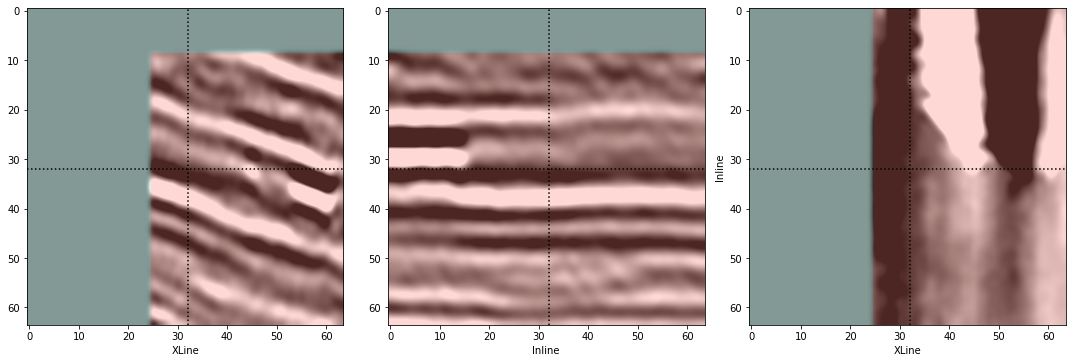

In [7]:
patch_idx = 50
il_idx = 32
xl_idx = 32
t_idx = 32

il_data, il_label = X_full[patch_idx, :, il_idx, :, 0], y_full[patch_idx, :, il_idx, :, 0]
xl_data, xl_label = X_full[patch_idx, ..., xl_idx, 0], y_full[patch_idx, ..., xl_idx, 0]
z_data, z_label = X_full[patch_idx, t_idx, ..., 0], y_full[patch_idx, t_idx]

vmin, vmax = -1, 1
seismic_kw = dict(vmin=vmin, vmax=vmax, cmap="gray_r", interpolation="bicubic")
label_kw = dict(vmin=0.5, vmax=12.5, cmap="Set3", interpolation="nearest")

fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(il_label, **label_kw)
ax[0].imshow(il_data, **seismic_kw, alpha=0.7)
ax[0].axhline(t_idx, color="k", linestyle=":")
ax[0].axvline(xl_idx, color="k", linestyle=":")
ax[0].set_xlabel("XLine")

ax[1].imshow(xl_label, **label_kw)
ax[1].imshow(xl_data, **seismic_kw, alpha=0.7)
ax[1].axhline(t_idx, color="k", linestyle=":")
ax[1].axvline(il_idx, color="k", linestyle=":")
ax[1].set_xlabel("Inline")

ax[2].imshow(z_label, **label_kw)
ax[2].imshow(z_data, **seismic_kw, alpha=0.7)
ax[2].axhline(il_idx, color="k", linestyle=":")
ax[2].axvline(xl_idx, color="k", linestyle=":")
ax[2].set_xlabel("XLine")
ax[2].set_ylabel("Inline")

fig.tight_layout()
vmin, vmax

In [8]:
train_split = 0.8
BATCH_SIZE = 16

full_ds = tf.data.Dataset.from_tensor_slices((X_full, y_full))
full_ds = full_ds.shuffle(len(full_ds), seed=42)
len(full_ds), len(full_ds) * train_split

(2080, 1664.0)

In [9]:
train_ds = full_ds.take(round(len(full_ds) * train_split))
val_ds = full_ds.skip(round(len(full_ds) * train_split))

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

len(train_ds), len(val_ds)

(104, 26)

In [10]:
layers = tf.keras.layers

def conv3x3x3_bn_relu_pool(input, channels, pool=True):
    x = layers.Conv3D(channels, 3, padding='same', kernel_initializer='he_normal')(input)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv3D(channels, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)

    if pool is True:
        pool = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    else:
        pool = x

    return pool, x

def convtrans2x2x2_concat_conv3x3x3_relu(input, channels, skip):
    x = layers.Conv3DTranspose(channels, 3, strides=2, padding='same')(input)
    x = layers.concatenate([skip, x], axis=4)
    x = layers.Conv3D(channels, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv3D(channels, 3, padding='same', kernel_initializer='he_normal')(x)
    x = layers.LeakyReLU()(x)

    return x

def unet(input_size=patch_size + (1,)):
    inputs = layers.Input(input_size)
    encoder_block1, encoder_skip1 = conv3x3x3_bn_relu_pool(inputs, 8, pool=True)
    encoder_block2, encoder_skip2 = conv3x3x3_bn_relu_pool(encoder_block1, 16, pool=True)
    encoder_block3, encoder_skip3 = conv3x3x3_bn_relu_pool(encoder_block2, 32, pool=True)
    encoder_block4, encoder_skip4 = conv3x3x3_bn_relu_pool(encoder_block3, 64, pool=True)
    encoder_block5, encoder_skip5 = conv3x3x3_bn_relu_pool(encoder_block4, 128, pool=True)

    bottleneck1, _ = conv3x3x3_bn_relu_pool(encoder_block5, 256, pool=False)
    bottleneck2, _ = conv3x3x3_bn_relu_pool(bottleneck1, 256, pool=False)

    decoder_block1 = convtrans2x2x2_concat_conv3x3x3_relu(bottleneck2, 128, encoder_skip5)
    decoder_block2 = convtrans2x2x2_concat_conv3x3x3_relu(decoder_block1, 64, encoder_skip4)
    decoder_block3 = convtrans2x2x2_concat_conv3x3x3_relu(decoder_block2, 32, encoder_skip3)
    decoder_block4 = convtrans2x2x2_concat_conv3x3x3_relu(decoder_block3, 16, encoder_skip2)
    decoder_block5 = convtrans2x2x2_concat_conv3x3x3_relu(decoder_block4, 8, encoder_skip1)

    outputs = layers.Conv3D(7, 1, padding='same', activation='softmax')(decoder_block5)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

model = unet()

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   224         ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 layer_normalization (LayerNorm  (None, 64, 64, 64,   16         ['conv3d[0][0]']                 
 alization)                     8)                                                            

In [12]:
counts = [np.sum(y_full == label, dtype='float32') for label in range(1, 7)]
total = np.sum(counts)
counts = [(total - count) / total for count in counts]
counts  # class weights (without 0)

[0.84979284, 0.5779001, 0.9586633, 0.7123653, 0.9900484, 0.91123]

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from focal_loss import SparseCategoricalFocalLoss
callbacks = [
    EarlyStopping(patience=9, verbose=1),
    ModelCheckpoint('facies_model.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(factor=1/3, patience=4, verbose=1),
]

optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.003)
loss = SparseCategoricalFocalLoss(gamma=2, from_logits=False, class_weight=[0.01, 0.85, 0.58, 0.96, 0.71, 0.99, 0.91])
model.compile(optimizer=optimizer, loss = loss, metrics = ['sparse_categorical_accuracy'])

In [14]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
)

Epoch 1/20


2022-02-24 13:31:11.927683: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-24 13:31:11.928183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - ETA: 0s - loss: 6.7003 - sparse_categorical_accuracy: 0.2449

2022-02-24 13:43:26.080783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 7.09855, saving model to facies_model.h5
104/104 [==============================] - 768s 7s/step - loss: 6.7003 - sparse_categorical_accuracy: 0.2449 - val_loss: 7.0986 - val_sparse_categorical_accuracy: 0.2317 - lr: 0.0030
Epoch 2/20
104/104 [==============================] - ETA: 0s - loss: 6.8418 - sparse_categorical_accuracy: 0.2485
Epoch 2: val_loss improved from 7.09855 to 6.67290, saving model to facies_model.h5
104/104 [==============================] - 760s 7s/step - loss: 6.8418 - sparse_categorical_accuracy: 0.2485 - val_loss: 6.6729 - val_sparse_categorical_accuracy: 0.2784 - lr: 0.0030
Epoch 3/20
104/104 [==============================] - ETA: 0s - loss: 6.8864 - sparse_categorical_accuracy: 0.2508
Epoch 3: val_loss did not improve from 6.67290
104/104 [==============================] - 760s 7s/step - loss: 6.8864 - sparse_categorical_accuracy: 0.2508 - val_loss: 6.7068 - val_sparse_categorical_accuracy: 0.2683 - lr: 0.0030
Epoch 4/2

In [15]:
model.load_weights("facies_model.h5")

In [16]:
full_ds = tf.data.Dataset.from_tensor_slices((X_full, y_full))
full_ds = full_ds.shuffle(len(full_ds), seed=42)

val_ds = full_ds.skip(round(len(full_ds) * train_split))
val_ds = val_ds.shuffle(len(val_ds))
val_ds = val_ds.batch(BATCH_SIZE)
val_batch = list(val_ds.take(1))
val_images = [image for image, label in val_batch]
val_predict = model.predict(val_images)

2022-02-24 15:50:39.526932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


/var/folders/4k/18fs79y57sl__pqgs7xrscj80000gn/T/ipykernel_24683/1298803412.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 7, figsize=(20,5))


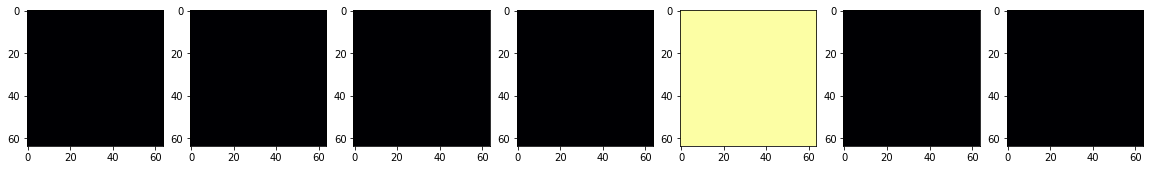

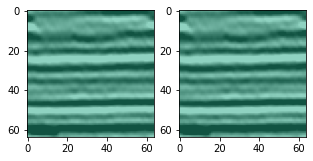

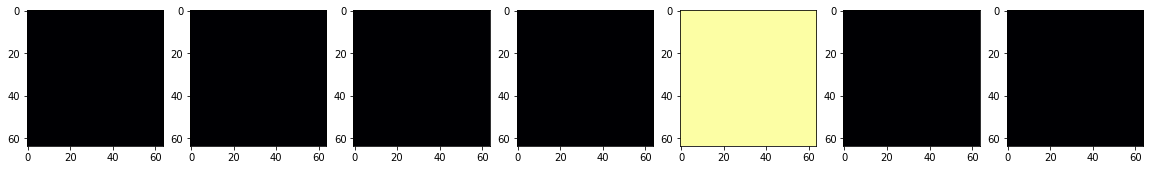

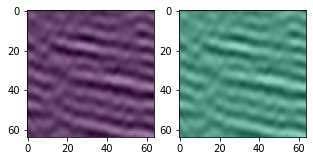

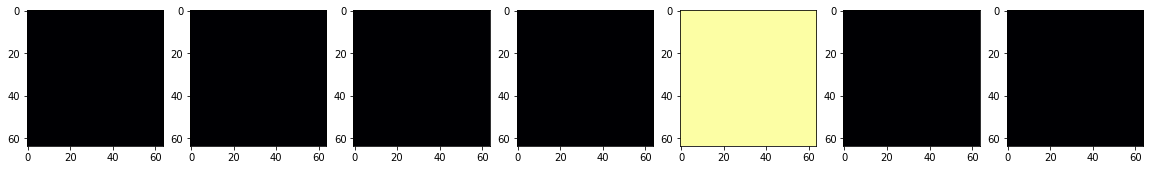

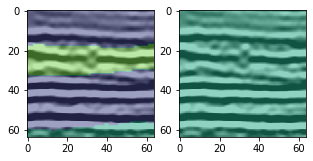

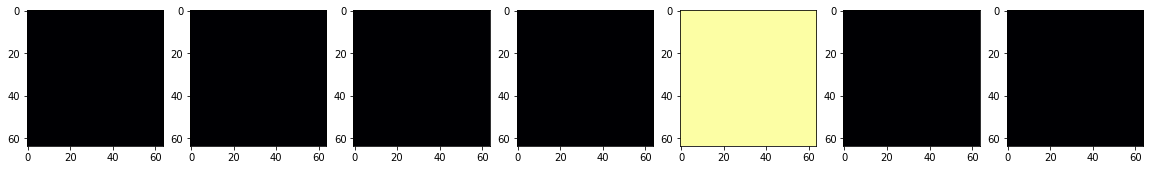

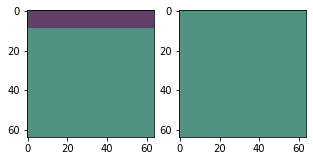

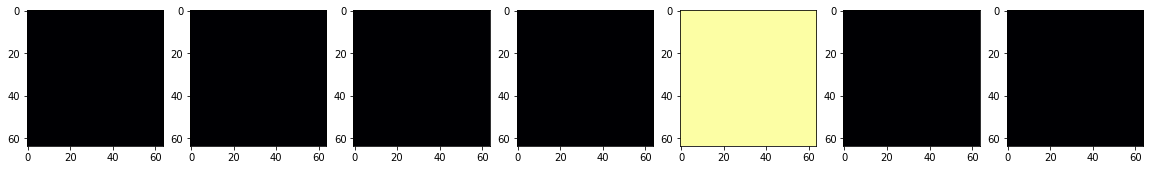

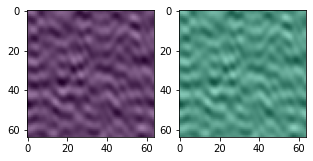

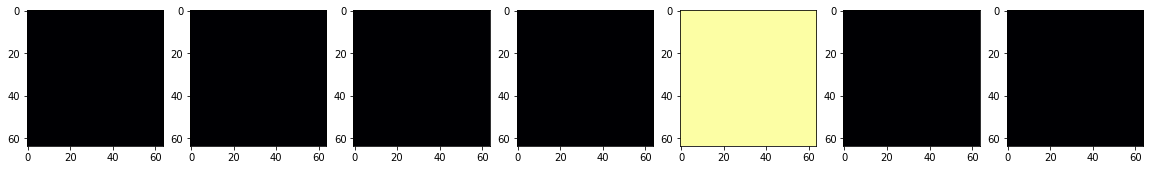

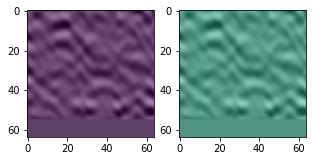

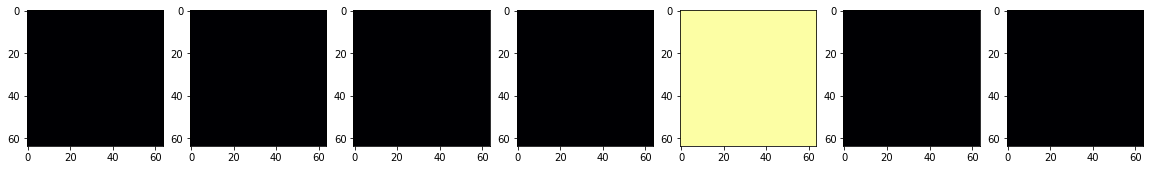

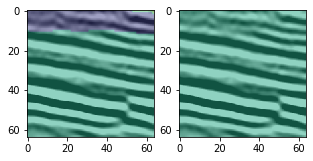

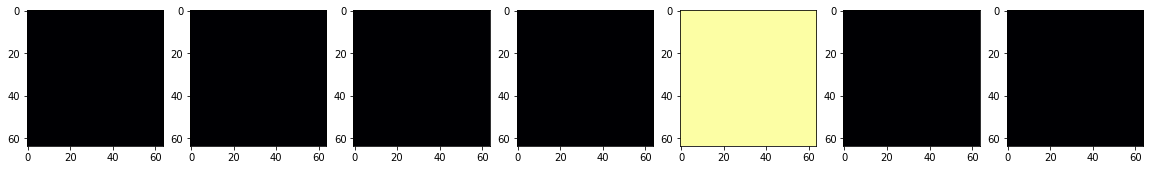

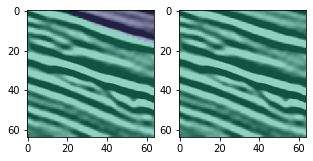

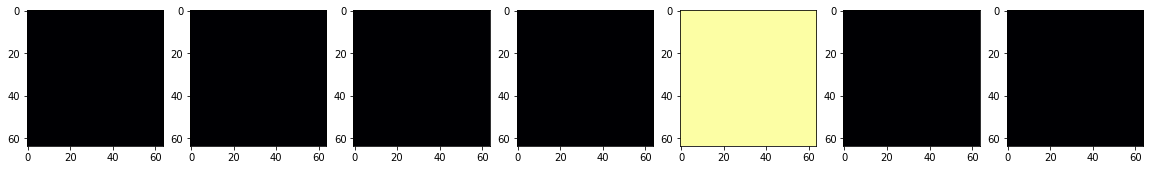

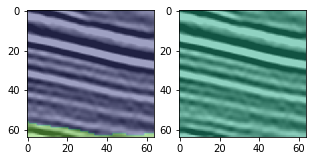

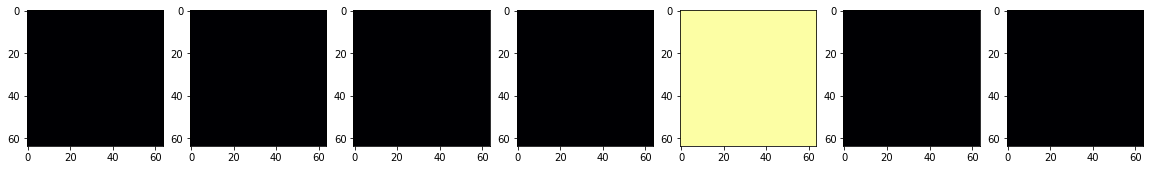

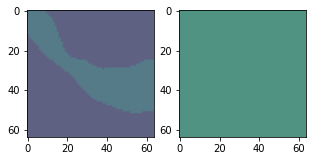

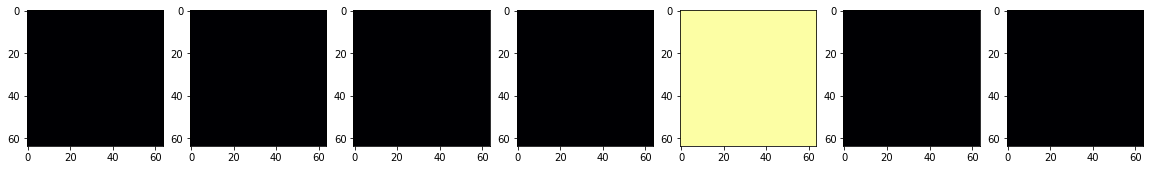

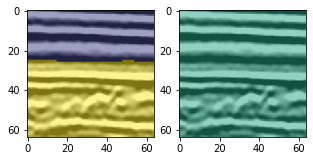

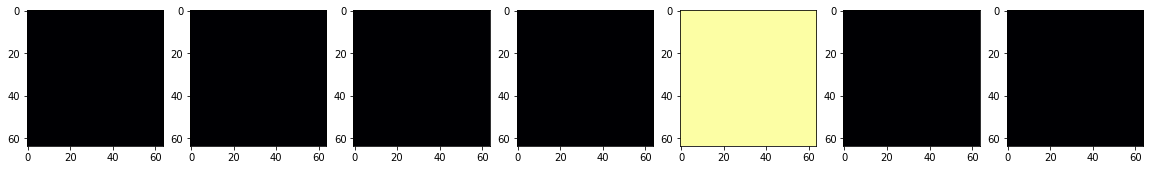

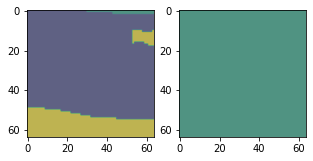

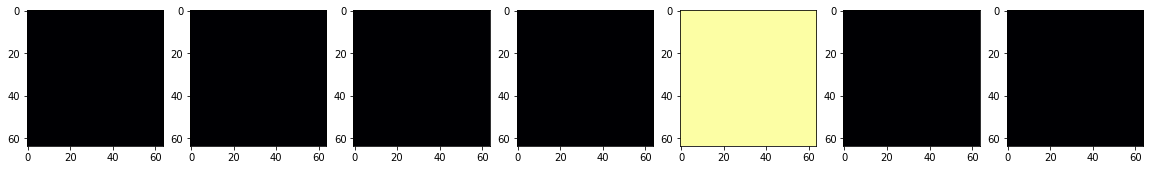

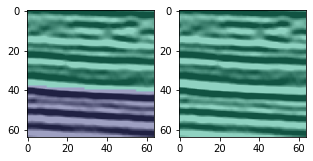

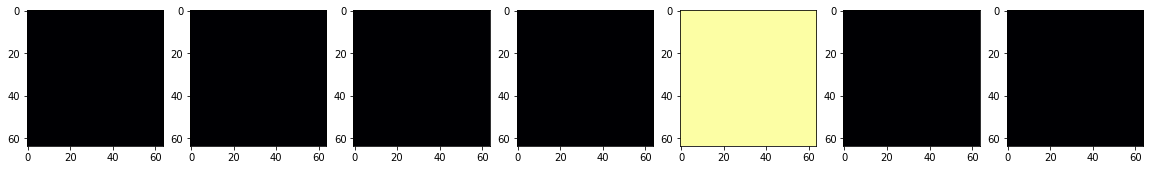

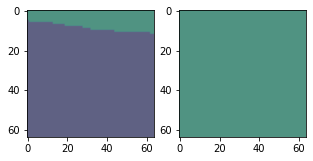

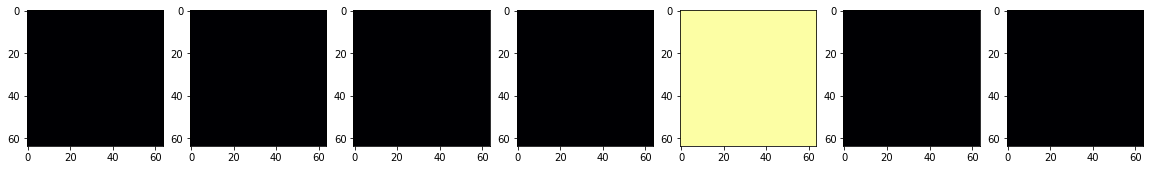

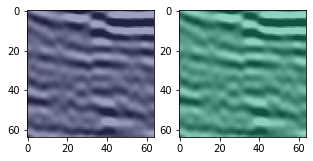

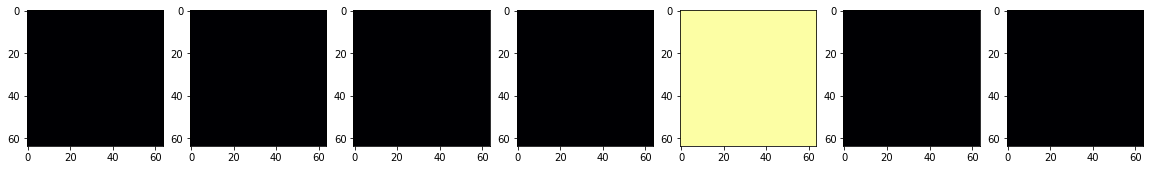

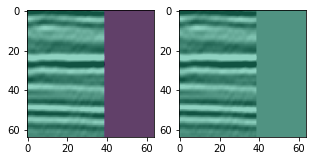

In [17]:
for img in range(BATCH_SIZE):
    fig, ax = plt.subplots(1, 7, figsize=(20,5))
    for idx in range(7):
        ax[idx].imshow(val_predict[img, ..., 32, idx], vmin=0, vmax=1, cmap='inferno')

    fig, ax = plt.subplots(1, 2, figsize=(5,5))
    ax[0].imshow(val_batch[0][1][img, ..., 32, 0], vmin=1, vmax=6)
    ax[0].imshow(val_batch[0][0][img, ..., 48, 0], alpha=0.5, vmin=-1, vmax=1, cmap='gray_r')

    ax[1].imshow(val_predict[img, ..., 32, :].argmax(-1), vmin=1, vmax=6)
    ax[1].imshow(val_batch[0][0][img, ..., 48, 0], alpha=0.5, vmin=-1, vmax=1, cmap='gray_r')